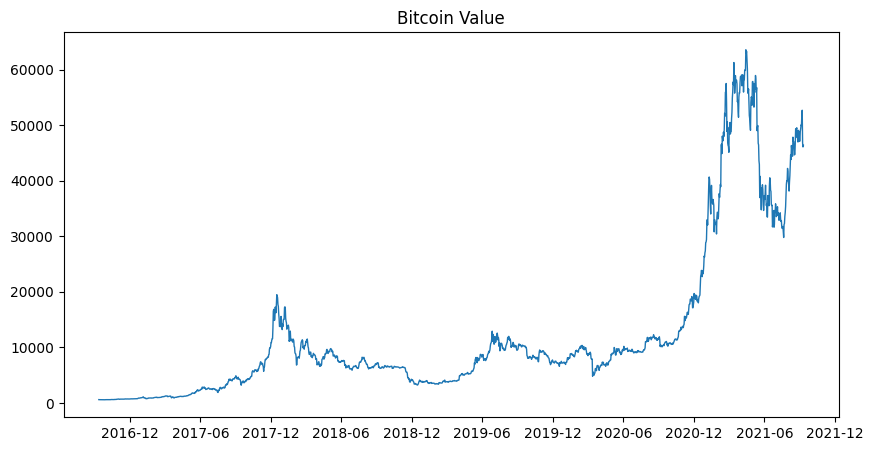

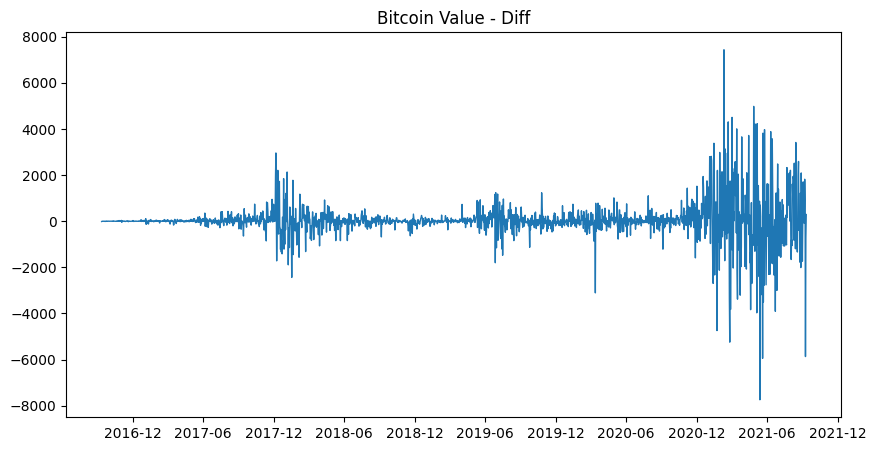

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from matplotlib.dates import date2num
from matplotlib.dates import MonthLocator
import matplotlib.pyplot as plt

data = pd.read_csv('2022_Problem_C_DATA/BCHAIN-MKPRU.csv')
input_param_name = 'Date'
output_param_name = 'Value'

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
value = data[[output_param_name]].values.flatten()
diff_val = data[[output_param_name]].diff()

plt.gcf().set_size_inches(10, 5)
plt.title("Bitcoin Value")
plt.plot(data['Date'], value, linestyle = '-', linewidth = 1)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))
plt.show()

plt.gcf().set_size_inches(10, 5)
plt.title("Bitcoin Value - Diff")
plt.plot(data['Date'], diff_val, linestyle = '-', linewidth = 1)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))
plt.show()

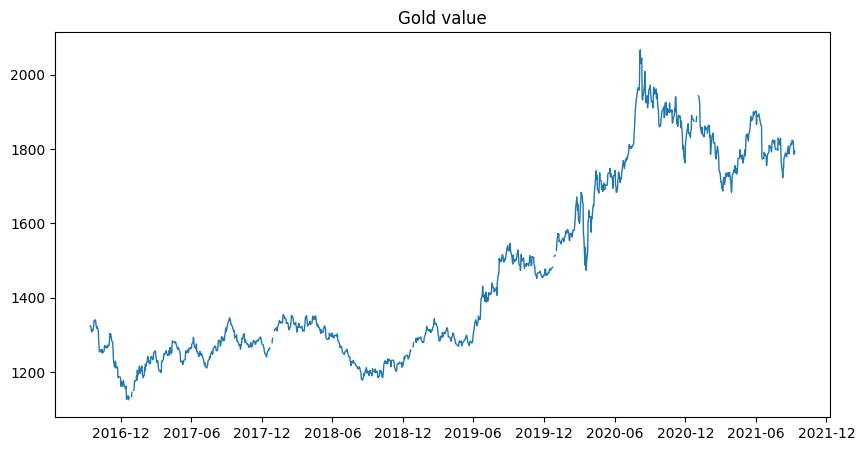

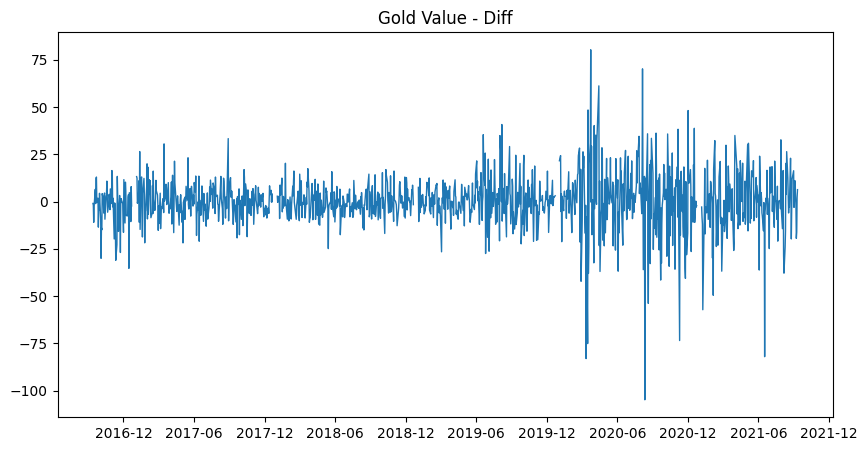

In [2]:
data = pd.read_csv('2022_Problem_C_DATA/LBMA-GOLD.csv')
input_param_name = 'Date'
output_param_name = 'USD (PM)'

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
value = data[[output_param_name]].values.flatten()
diff_val = data[[output_param_name]].diff()

plt.gcf().set_size_inches(10, 5)
plt.plot(data['Date'], value, linestyle = '-', linewidth = 1)
plt.title("Gold value")
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))
plt.show()

plt.gcf().set_size_inches(10, 5)
plt.title("Gold Value - Diff")
plt.plot(data['Date'], diff_val, linestyle = '-', linewidth = 1)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=6))
plt.show()

In [3]:
data = pd.read_csv('2022_Problem_C_DATA/BCHAIN-MKPRU.csv',index_col= 'Date', parse_dates=['Date'])

/var/folders/f0/byzm0qjj7f750yfysp4rl_340000gn/T/ipykernel_5383/1137342321.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('2022_Problem_C_DATA/BCHAIN-MKPRU.csv',index_col= 'Date', parse_dates=['Date'])


In [4]:
data.index = pd.to_datetime(data.index)
data['Value']
sub = data.loc['2016-09':'2021-12','Value']
sub.head()

Date
2016-09-11    621.65
2016-09-12    609.67
2016-09-13    610.92
2016-09-14    608.82
2016-09-15    610.38
Name: Value, dtype: float64

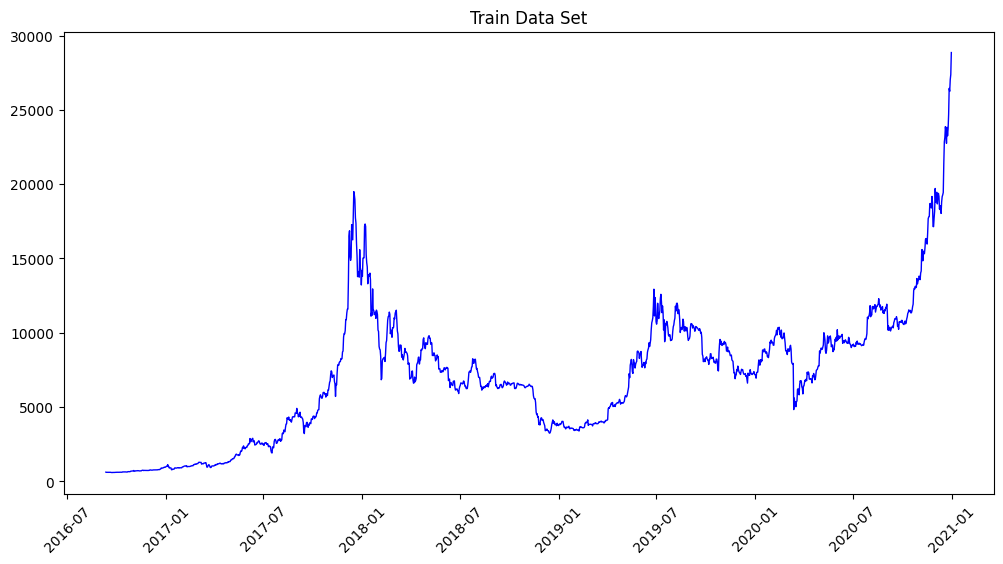

In [5]:
# 划分训练集 / 测试集
train = sub.loc['2016':'2020']
pred = sub.loc['2020':'2021']
# 查看训练集的时间 / 数据
plt.figure(figsize=(12,6))
plt.plot(train, linewidth = 1, color= 'b')
plt.title("Train Data Set")
plt.xticks(rotation = 45)
plt.show()


In [6]:
 # 差分
data['diff_1'] = data['Value'].diff(1)
data['diff_2'] = data['diff_1'].diff(1)

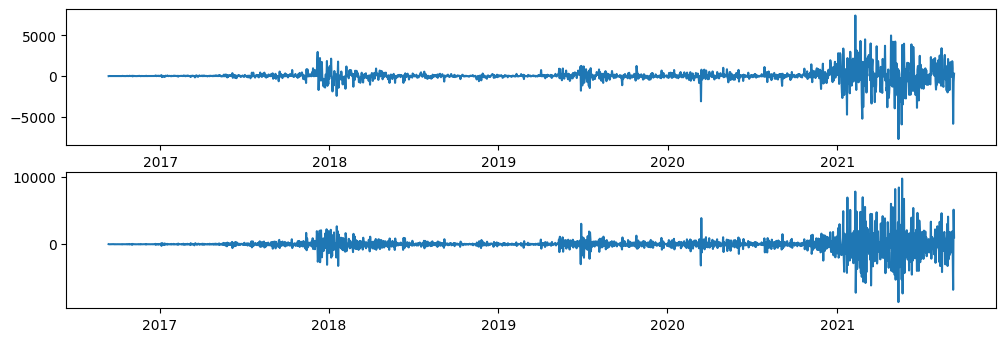

In [7]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(312)
ax1.plot(data['diff_1'])

ax2 = fig.add_subplot(313)
ax2.plot(data['diff_2'])

plt.show()

# ADF

In [8]:
import pandas as pd
import statsmodels.api as stm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

#计算原始序列，一阶差分，二阶差分序列的单位根检验结果
data['diff_1'] = data['diff_1'].fillna(0) #填补缺失值
data['diff_2'] = data['diff_2'].fillna(0)

timeseries_adf = ADF(data['Value'])
timeseries_diff1_adf = ADF(data['diff_1'])
timeseries_diff2_adf = ADF(data['diff_2'])

print("p_timeseries:", timeseries_adf[1:5])
print("p_diff1series:", timeseries_diff1_adf[1:5])
print("p_diff2series:", timeseries_diff2_adf[1:5])

p_timeseries: (0.9338707177253287, 24, 1801, {'1%': -3.4339861159726306, '5%': -2.863146142843122, '10%': -2.5676250581282964})
p_diff1series: (9.973933990341535e-14, 23, 1802, {'1%': -3.4339840952648695, '5%': -2.8631452508003057, '10%': -2.567624583142913})
p_diff2series: (1.2865806497701934e-28, 25, 1800, {'1%': -3.4339881389288407, '5%': -2.863147035877915, '10%': -2.567625533641975})


In [9]:
print(train)

Date
2016-09-11      621.65
2016-09-12      609.67
2016-09-13      610.92
2016-09-14      608.82
2016-09-15      610.38
                ...   
2020-12-27    26443.21
2020-12-28    26246.58
2020-12-29    27036.69
2020-12-30    27376.37
2020-12-31    28856.59
Name: Value, Length: 1573, dtype: float64


- 一次差分后结果通过稳定性检验，d取1

# 确定参数 （p,q）

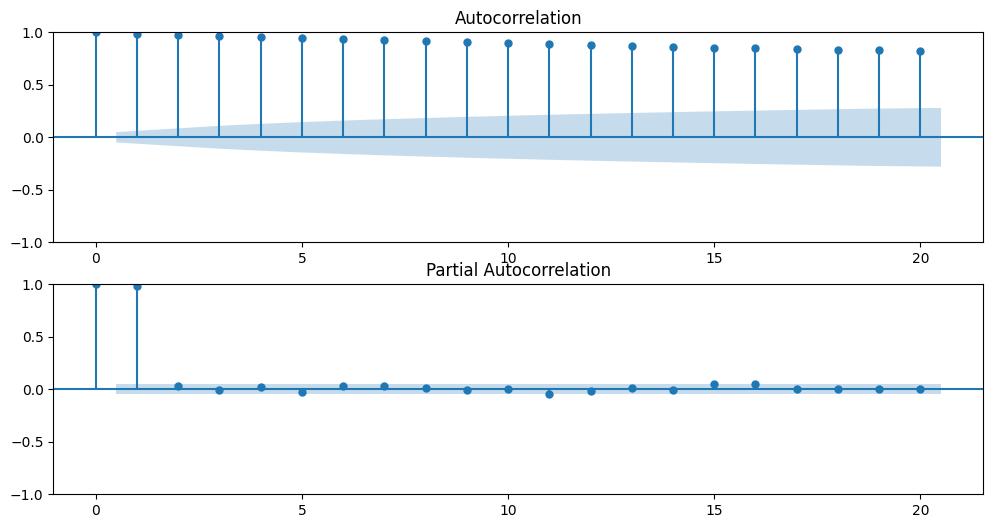

In [10]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(211)
fig = stm.graphics.tsa.plot_acf(train, lags = 20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')

ax2 = fig.add_subplot(212)
fig = stm.graphics.tsa.plot_pacf(train, lags = 20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')

plt.show()


In [11]:
import itertools
import seaborn as sns

p_min = 0
d_min = 1 
q_min = 0
p_max = 9
d_max = 1
q_max = 9

In [12]:
# Initialise a dataframe for results storage, using BIC
result_bic = pd.DataFrame(index = ['AR{}'.format(i) for i in range(p_min,p_max+1)],
                          columns = ['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p == 0 and d == 0 and q == 0:
        result_bic.loc['AR{}'.format(p),'MA{}'.format(q)] = np.nan
        continue
    try:
        model = stm.tsa.ARIMA(train,order=(p,d,q))
        result = model.fit()
        result_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = result.bic
    except:
        continue

/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, 

In [13]:
result_bic

,MA0,MA1,MA2,MA3,MA4,MA5,MA6,MA7,MA8,MA9
AR0,22996.222711,23002.595337,23008.138334,23013.684238,23013.224843,23019.519493,23026.353767,23033.756595,23037.276794,23031.701678
AR1,23002.520708,23001.635802,23012.89894,23019.019809,23019.897125,23024.09299,23033.608995,23041.003307,23040.935191,23033.33548
AR2,23008.055401,23013.287066,23011.31297,23018.38796,23019.260517,23026.251011,23027.27091,23038.551891,23038.597249,23040.666819
AR3,23014.116806,23019.800652,23028.02344,23012.506921,23025.518746,23033.208844,23038.045813,23040.104019,23045.801281,23044.36224
AR4,23014.025557,23019.958081,23018.79145,23025.406291,23031.422138,23039.650139,23047.052039,23047.123095,23054.180921,23051.349664
AR5,23018.710116,23023.359619,23025.709094,23033.01342,23037.117227,23034.313032,23041.742984,23043.340702,23059.214757,23059.132389
AR6,23024.952571,23032.316644,23033.451227,23039.3042,23042.362036,23041.773872,23049.146608,23052.227777,23063.452387,23063.37647
AR7,23032.316812,23039.68154,23040.681492,23044.418974,23050.748671,23046.311958,23054.597899,23055.525594,23066.233966,23068.058745
AR8,23038.156504,23042.792206,23038.814195,23045.735773,23052.135612,23052.878122,23062.951151,23067.434283,23070.842646,23074.440531
AR9,23032.283332,23034.46614,23041.783636,23044.451531,23050.589531,23057.728435,23064.917106,23066.519757,23073.918117,23083.149299


In [14]:
result_bic = result_bic[result_bic.columns].astype(float)

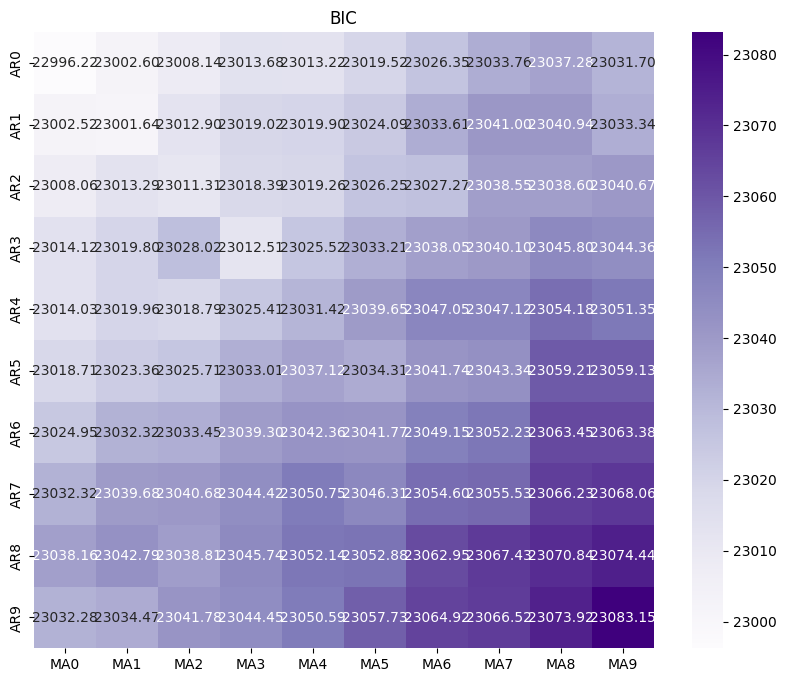

In [15]:
fig,ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(result_bic,
                 mask=result_bic.isnull(),
                 ax = ax,
                 annot = True,
                 fmt = '.2f',
                 cmap = 'Purples')
ax.set_title('BIC')
plt.show()

In [16]:
result_bic.stack().idxmin()

('AR0', 'MA0')

In [17]:
train_results = stm.tsa.arma_order_select_ic(train,ic = ['aic','bic'], trend='n', max_ar=10, max_ma = 10)

print(train_results.aic_min_order)
print(train_results.bic_min_order)

/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/

(1, 10)
(1, 0)


/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
p = 8
q = 9
d = 0

model = stm.tsa.ARIMA(train, order=(p,d,q))
result = model.fit()
resit = result.resid

/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aiden/micromamba/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarn

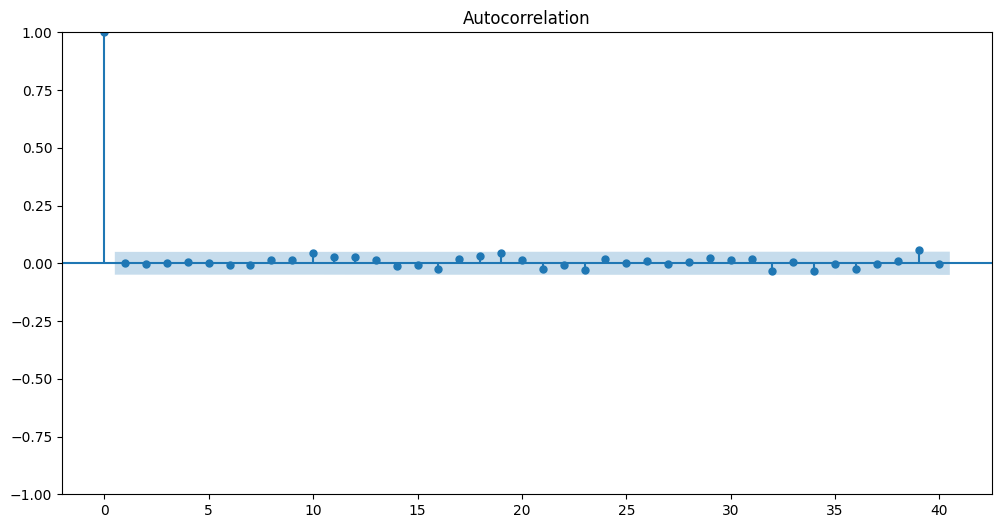

In [30]:
fig, ax = plt.subplots(figsize = (12,6))
ax = stm.graphics.tsa.plot_acf(resit, lags=40, ax=ax)
plt.show()

In [31]:
predict = result.predict(dynamic=False)
print(predict)

2016-09-11     7010.887277
2016-09-12      624.651440
2016-09-13      612.445745
2016-09-14      613.685948
2016-09-15      612.299269
                  ...     
2020-12-27    24872.656662
2020-12-28    26372.446489
2020-12-29    26278.032354
2020-12-30    27118.658123
2020-12-31    27393.577652
Freq: D, Name: predicted_mean, Length: 1573, dtype: float64


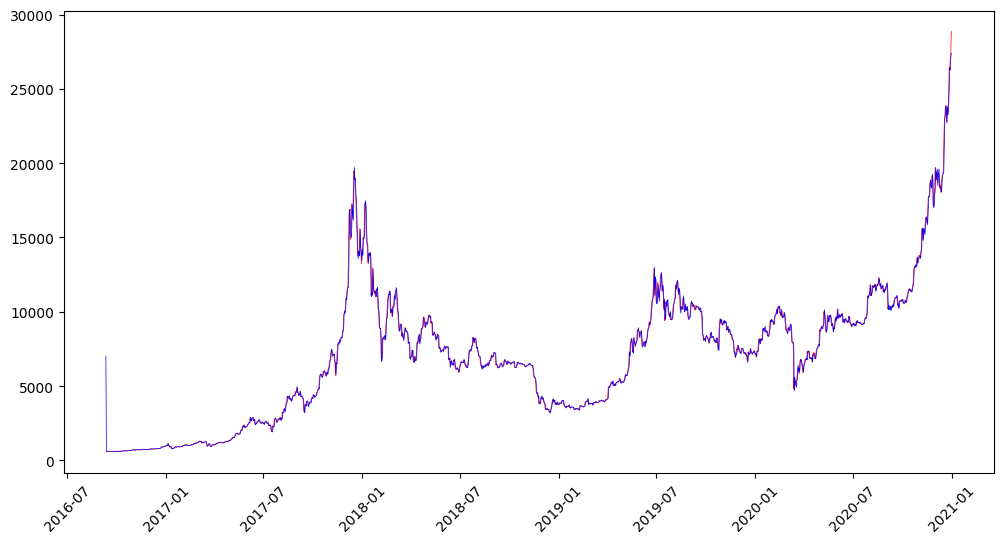

In [36]:
plt.figure(figsize = (12,6))
plt.plot(train, color = 'r', linewidth = 0.5)
plt.xticks(rotation = 45)
plt.plot(predict, color = 'b', linewidth = 0.5)
plt.show()

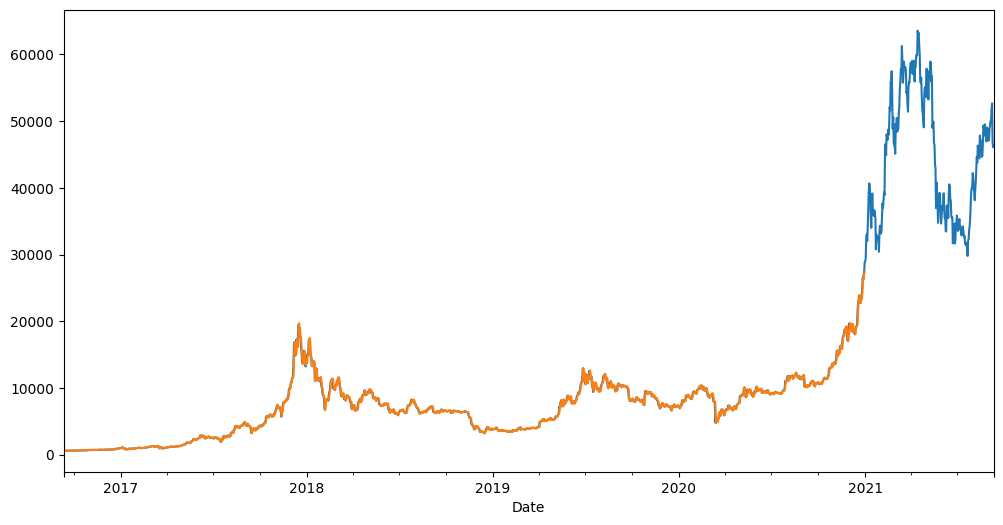

In [38]:
forecast_values = result.predict(start=len(train), end=len(train) + 1000, dynamic=False)
fig,ax = plt.subplots(figsize = (12,6))
ax = sub.plot(ax=ax)
predict.plot(ax=ax)
plt.show()